In [1]:
!date

Fri Feb  2 10:06:29 EST 2018


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.conv_learner import *
from planet import *
import operator
import os

In [4]:
project_name = 'planet-understanding-the-amazon-from-space'

In [5]:
PATH='/home/paperspace/data/planet/'
assert os.path.exists(PATH)

In [6]:
arch=resnet50
size=64
bs=64
metrics=[f2]

In [7]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [8]:
label_csv = f'{PATH}train_v2.csv'

In [9]:
no_of_rows = len(list(open(label_csv)))-1

In [10]:
val_idxs = get_cv_idxs(no_of_rows)

In [11]:
print(val_idxs.shape)
val_idxs

(8095,)


array([34602, 11243, 14499, ..., 13041, 22865, 25088])

In [12]:
label_df = pd.read_csv(label_csv)

In [13]:
label_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [14]:
label_df.pivot_table(index='tags', aggfunc=len).sort_values('image_name', ascending=False)[:10]

,image_name
tags,
clear primary,13636
partly_cloudy primary,3630
cloudy,2089
clear primary water,1850
agriculture clear primary road,1680
agriculture clear primary,1626
haze primary,1471
agriculture clear cultivation primary,1170
agriculture clear habitation primary road,1125


In [15]:
data = get_data(size)

In [16]:
x, y = next(iter(data.val_dl))

In [17]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [18]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

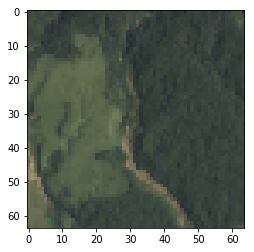

In [19]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] )

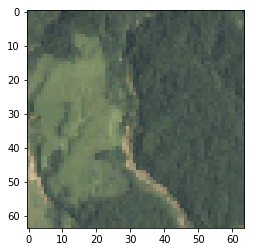

In [20]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] * 1.3 ) # TIP : Multiply by a value if the image is too hazy

In [21]:
data = get_data(size)

In [22]:
data = data.resize(int(size*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

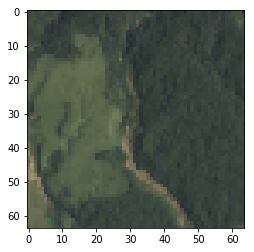

In [23]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] )

## Train model

In [24]:
learn = ConvLearner.pretrained(arch, data, metrics=metrics)

In [25]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.228581   0.397545   0.796371  



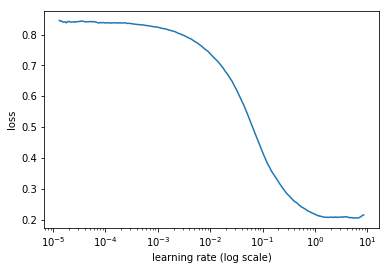

In [26]:
learn.sched.plot()

In [27]:
learning_rate = 0.2

In [28]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.143698   0.134383   0.881754  
    1      0.137423   0.128747   0.88706                     
    2      0.136455   0.126963   0.888201                    
    3      0.135896   0.126049   0.890035                    
    4      0.132757   0.123624   0.892108                    
    5      0.127612   0.121714   0.893871                    
    6      0.127427   0.121368   0.894729                    

CPU times: user 7min 58s, sys: 2min 14s, total: 10min 13s
Wall time: 6min 46s


[0.12136812, 0.8947294635039429]

##### As sat images are not part of imagnet, we divide by smaller numbers as we want to train the entire network from scratch. Well kind of, we initially use the weights from imagnet model as something is better than nothing and also, imagnet initial layers actually detect basic structures like edges etc.

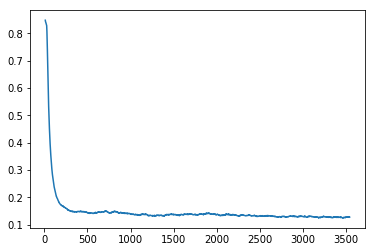

In [29]:
learn.sched.plot_loss()

In [30]:
learning_rates = np.array([learning_rate/9, learning_rate/3, learning_rate]) 

In [31]:
learn.unfreeze()

In [32]:
%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.117257   0.105157   0.910595  
    1      0.115297   0.102572   0.91306                     
    2      0.10374    0.098139   0.91715                     
    3      0.109693   0.101574   0.913786                    
    4      0.102843   0.097502   0.918408                     
    5      0.0963     0.095278   0.919                        
    6      0.092235   0.095612   0.919145                     

CPU times: user 13min 45s, sys: 4min 14s, total: 18min
Wall time: 14min 32s


[0.09561222, 0.9191449565518915]

In [33]:
%time learn.save(f'{project_name}_last_layer_{size}')

CPU times: user 32 ms, sys: 96 ms, total: 128 ms
Wall time: 326 ms


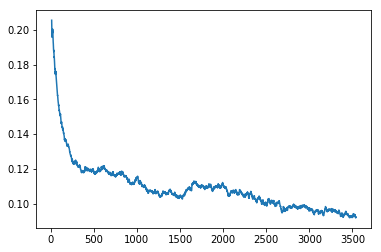

In [34]:
learn.sched.plot_loss()

### Increase pic size

In [35]:
size = 128

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.092519   0.092095   0.921748  
    1      0.092297   0.091465   0.921253                     
    2      0.093042   0.091178   0.921837                     
    3      0.09196    0.091486   0.922851                     
    4      0.092925   0.090396   0.923587                     
    5      0.092059   0.090069   0.923377                     
    6      0.089327   0.089181   0.925198                     

CPU times: user 28min 7s, sys: 3min 47s, total: 31min 54s
Wall time: 12min 1s


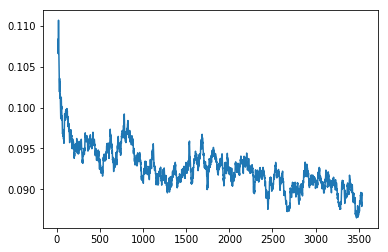

In [36]:
learn.set_data(get_data(size))
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.093969   0.08639    0.929423  
    1      0.09628    0.089582   0.926398                     
    2      0.089054   0.08474    0.930207                     
    3      0.095412   0.093992   0.920253                     
    4      0.0926     0.08794    0.926221                     
    5      0.086111   0.083716   0.930854                     
    6      0.081951   0.08297    0.931138                     

CPU times: user 41min 21s, sys: 8min 8s, total: 49min 30s
Wall time: 30min 50s


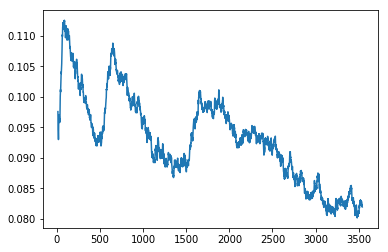

In [37]:
learn.unfreeze()
%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()
learn.save(f'{project_name}_last_layer_{size}')

In [38]:
size = 256

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.088013   0.088051   0.925393  
    1      0.087844   0.088038   0.924889                     
    2      0.088158   0.086674   0.92745                      
    3      0.087711   0.086545   0.927071                     
    4      0.089127   0.085549   0.928266                     
    5      0.088338   0.085289   0.928349                     
    6      0.084922   0.085514   0.928126                     

CPU times: user 1h 9min 10s, sys: 14min 9s, total: 1h 23min 19s
Wall time: 44min 4s


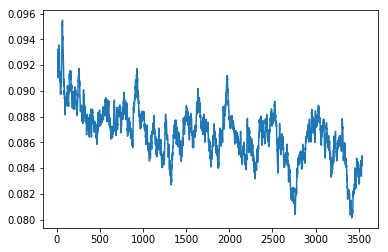

In [39]:
learn.set_data(get_data(size))
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()

In [ ]:
learn.unfreeze()
%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()
learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 0/506 [00:00<?, ?it/s]                       


Exception in thread Thread-47:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 89%|████████▉ | 452/506 [12:39<01:30,  1.68s/it, loss=0.0825]

In [41]:
# multi_preds, y = learn.TTA()
# preds = np.mean(multi_preds, 0)

KeyboardInterrupt: 

In [ ]:
# print(multi_preds.shape)
# print(preds.shape)
# print(y.shape)

In [ ]:
# preds[0]

In [ ]:
# y[0]

In [ ]:
# f2(preds,y)

In [ ]:
tta = learn.TTA()

In [ ]:
f2(*tta)

In [ ]:
test_multi_preds, test_y = learn.TTA(is_test=True) # doesn't return test_y for test set as the label is to be predicted!
test_preds = np.mean(test_multi_preds, 0)

In [ ]:
print(test_multi_preds.shape)
print(test_preds.shape)
print(test_y.shape)

In [ ]:
test_y.max()

In [ ]:
test_preds[0]

In [ ]:
test_preds[240]

In [ ]:
test_probs = np.round(test_preds)

In [ ]:
test_probs.shape

In [ ]:
test_probs[0]

In [ ]:
print(test_probs[240]) # all zeros?

In [ ]:
f2(test_preds, test_probs)

In [ ]:
#def get_test_classes(probs, classes):
#    prob_idxs = np.argwhere(probs==1) # Indexs of 1's in every row of probs ([0 1 0 1 0 1 0])
#    prob_idxs = prob_idxs.flatten().tolist() # Convert the o/p to a list after flatting it as required by itemgetter
    #return operator.itemgetter(*prob_idxs)(classes) 

In [ ]:
def get_test_classes(probs, classes):
    prob_idxs = np.argwhere(probs==1) # Indexs of 1's in every row of probs ([0 1 0 1 0 1 0])
    prob_idxs = prob_idxs.flatten().tolist() # Convert the o/p to a list after flatting it as required by itemgetter

    all_probs_zero = 0
    if not prob_idxs:
        all_probs_zero =+ 1
        prob_idxs = [10]  # default to haze

    if all_probs_zero != 0: print("All 0 probs : {}".format(all_probs_zero))
    #return operator.itemgetter(*(np.argwhere(probs==1)).flatten().tolist())(classes)    

    classes = operator.itemgetter(*prob_idxs)(classes)
    # If there is just one class, then the itemgetter returns a string instead of a tuple
    # Convert to tuple. Else, the join will put a space in between every letter in the aingle word.
    # E.g.: c l o u d y instead of cludy
    if type(classes) == str: classes = (classes,) 
        
    return classes

In [ ]:
a = get_test_classes(test_probs[4], learn.data.classes)
print(type(a))
print(len(a))
a

In [ ]:
#operator.itemgetter(a)(learn.data.classes) 
#test_classes = [' '.join( get_test_classes(probs, learn.data.classes) ) for probs in test_probs]
#[print( ' '.join( operator.itemgetter(*(np.argwhere(a==1)).flatten().tolist())(learn.data.classes) ) ) for a in test_probs[230:250]]
#test_classes = [' '.join( operator.itemgetter(*(np.argwhere(a==1)).flatten().tolist())(learn.data.classes) )  for a in test_probs]

In [ ]:

test_classes = [ ' '.join( get_test_classes(probs, learn.data.classes) ) for probs in test_probs]


In [ ]:
test_classes[:5]
#print(len(test_classes))

In [ ]:
fn = PATH + get_data(224).test_ds.fnames[240]
fn

In [ ]:
fnames = [f[9:-4] for f in learn.data.test_ds.fnames]
len(fnames)

In [ ]:
fnames[240]

In [ ]:
subm = np.stack([fnames, test_classes], axis=1)
subm[:5]

In [ ]:
test_df = pd.DataFrame(subm)

In [ ]:
test_df.head()

In [ ]:
#test_df.insert(0, 'image_name', fnames )

# Submit to kaggle

In [ ]:
!pwd

In [ ]:
now = datetime.datetime.now()
submission_file_name = f'{project_name}-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, subm, fmt='%s,%s', header='image_name,tags', comments='')

In [ ]:
from IPython.display import FileLink
FileLink(submission_file_name)

In [ ]:
!date